In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Orchids Keras EfficientNet


## Import Package


In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("Tensorflow version " + tf.__version__)

## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:


In [5]:
SEED = 5397
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.set_soft_device_placement(True)

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

## Const & Inputs

Here are all of the parameters to change for the run.


In [7]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "/content/drive/MyDrive/Colab Notebooks/aidea-orchids"

# Folder of the training data
training_folder = 'train'

# Folder of the testing data
testing_folder = 'public'

# Number of classes in the dataset
num_classes = 219

# Image size for model
image_size = 456

# Get the shape of the input layer
input_shape = (image_size, image_size, 3)

## Helper Functions

Before we write the code for adjusting the models, lets define a few helper functions.


In [9]:
import cv2
def load_image_and_resize(path, new_size=224, resize_method="resize", padding_method="wrap"):
    """Use CV2 to read image, and resize the image to make the aspect ratio.

    Arguments:
    ----------
        path: string, default=None
            image path. 

        new_size: number, default=500
            desired image size.

        resize_method: 'resize' or 'padding', default='resize'
            resize: only resize.
            padding: padding and resize.

        padding_method: 'wrap' or 'constant'
            wrap: take mirrored pixel padding.
            constant: border padding to a fixed value.

    Returns:
    --------
        image_rgb: 3d-array
            image vector converted to rgb format.
    """
    image = cv2.imread(path)
    height, width, channel = image.shape

    if resize_method == "padding":
        # resize by ratio
        ratio = new_size/max(height, width)
        new_height, new_width = int(ratio * height), int(ratio * width)
        image = cv2.resize(image, (new_width, new_height))

        # calculate boundaries
        top, bottom = (new_size-new_height)//2, (new_size-new_height)//2
        if top + bottom + height < new_size:
            bottom += 1
        left, right = (new_size-new_width)//2, (new_size-new_width)//2
        if left + right + width < new_size:
            right += 1

        # padding
        if padding_method == "wrap":
            image = cv2.copyMakeBorder(
                image, top, bottom, left, right, cv2.BORDER_WRAP)
        elif padding_method == "constant":
            image = cv2.copyMakeBorder(
                image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    elif resize_method == "resize":
        image = cv2.resize(image, (new_size, new_size),
                           interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
!pip install -U scikit-learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def evaluate(y_true, y_pred,zero_division = 1):
    labels = sorted(list(set(y_true + y_pred)))
    eval_result = classification_report(
        y_true, y_pred, target_names=labels, 
        output_dict=True, zero_division=zero_division
    )['weighted avg']
    eval_result['accuracy'] = accuracy_score(y_true, y_pred)
    eval_result['final score'] = (eval_result['f1-score']+eval_result['accuracy'])/2
    return eval_result

## Data Preprocessing

Include: laod data, encode categorical features, split data, normalize data, and save data.


### Load Data

The training set has been randomly split into train (80%) and valid (20%) in advance.


In [11]:
fullset = pd.read_csv(f'{path}/data/train.csv')
fullset.groupby('set').count()

,filename,category
set,,
train,1752,1752
valid,438,438


In [12]:
train = fullset[fullset['set'].eq('train')].reset_index(drop=True)
valid = fullset[fullset['set'].eq('valid')].reset_index(drop=True)

Read testing set from the folder.


In [13]:
test = pd.DataFrame({'filename': [f for f in os.listdir(f'{path}/data/{testing_folder}') if os.path.isfile(os.path.join(f'{path}/data/{testing_folder}', f))]})

Process data.


In [13]:
tqdm.pandas()
train["vector"] = train['filename'].progress_apply(lambda x: load_image_and_resize(f'{path}/data/{training_folder}/{x}', new_size=image_size, resize_method="resize"))
tqdm.pandas()
valid["vector"] = valid['filename'].progress_apply(lambda x: load_image_and_resize(f'{path}/data/{training_folder}/{x}', new_size=image_size, resize_method="resize"))
tqdm.pandas()
test["vector"] = test['filename'].progress_apply(lambda x: load_image_and_resize(f'{path}/data/{testing_folder}/{x}', new_size=image_size, resize_method="resize"))

### Encode categorical features

OneHotEncoder.


In [15]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(fullset['category'].values.reshape(-1, 1))
train['class'] = list(np.array(enc.transform(train['category'].values.reshape(-1, 1)).toarray().tolist()))
valid['class'] = list(np.array(enc.transform(valid['category'].values.reshape(-1, 1)).toarray().tolist()))

## EfficientNet modelling + training

Using EfficientNetB0~B7.


### Initialize and Reshape the Networks


In [14]:
def get_reducelr():
    return tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=np.sqrt(0.1),
        patience=10,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0.5e-7,
    )

In [15]:
def get_checkpoint(model_name, monitor):
    return tf.keras.callbacks.ModelCheckpoint(
        model_name,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        save_freq='epoch'
    )

In [16]:
def get_early_stop(patience):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0,
        patience=patience,
        restore_best_weights=True
    )

In [17]:
def get_augmentation():
    augmentation = tf.keras.models.Sequential()
    augmentation.add(tf.keras.layers.RandomContrast(factor=0.15))
    augmentation.add(tf.keras.layers.RandomFlip('horizontal_and_vertical'))
    augmentation.add(tf.keras.layers.RandomZoom(0.15, 0.15))
    augmentation.add(tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15))
    augmentation.add(tf.keras.layers.RandomRotation(factor=0.15))
    return augmentation

In [18]:
def get_model(input_shape, num_classes, learning_rate=5e-04, dropout=0.2, isAugmentationActivated=False):
    model = tf.keras.models.Sequential()
    if(isAugmentationActivated):
      model.add(get_augmentation())
    model.add(tf.keras.applications.EfficientNetB7(input_shape=input_shape, include_top=False, weights='imagenet', drop_connect_rate=dropout))
    model.add(tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"))
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.he_uniform(seed=5397), name="pred"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model  

In [19]:
def get_batch_dataset(train, valid, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((np.array(train['vector'].tolist()), np.array(train['class'].tolist()))).shuffle(10000, seed=5397).batch(batch_size,drop_remainder=True)
    valid_ds = tf.data.Dataset.from_tensor_slices((np.array(valid['vector'].tolist()), np.array(valid['class'].tolist()))).batch(batch_size,drop_remainder=True)
    return train_ds, valid_ds

### Visualize data augmentation


In [ ]:
# n = 30
# augmentation = get_augmentation()
# plt.figure(figsize=(10,10))
# image, label = train_x[n], train_y[n]
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     aug_img = augmentation(image)
#     plt.imshow(aug_img.numpy().astype("uint8"))
#     plt.title("{}".format(np.argmax(label)))
#     plt.axis("off")

### Modelling


In [45]:
# [10, 30, 50, 100, 150]
EPOCHS = 500

# [16, 32(default), 64, 128, 256, 512, 1024]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# learning rate
LR_START = 5e-04

DROPOUT = 0.2

# Define model name
model_name = f'efficientnetb7-transfer-trainable-datagen15-simple-epochs{EPOCHS}-batchsize{BATCH_SIZE}-lr{LR_START:.0e}-reducelr-dropout{int(DROPOUT*100)}-{input_shape[0]}'

In [28]:
# Dataset to train
train_ds, valid_ds = get_batch_dataset(train, valid, BATCH_SIZE)

In [ ]:
# GPU Data Augmentation
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=5,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )
# train_datagen.fit(train_x)
# model.fit(train_datagen.flow(train_x, train_y, batch_size=batch_size),...)

In [25]:
with strategy.scope():    
    model = get_model(input_shape, num_classes, LR_START, DROPOUT, isAugmentationActivated=True)

In [ ]:
start = time.time()

# Train model
history = model.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=valid_ds,
  verbose=2,
  callbacks=[
    get_checkpoint(f'{path}/models/{model_name}.h5', 'val_categorical_accuracy'), 
    get_early_stop(50),
    get_reducelr(),
  ],
)

# Save history
pd.DataFrame(history.history).to_csv(f'{path}/logs/{model_name}.csv', index=False)

end = time.time()
print(format(end-start))

epochs:  81


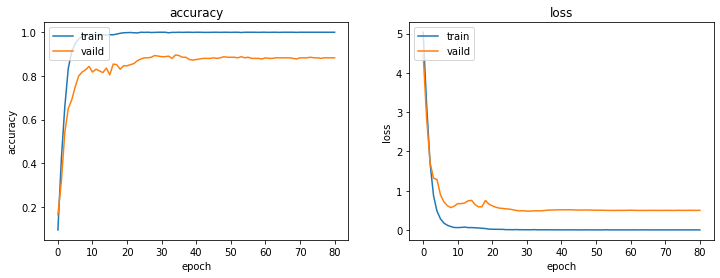

In [46]:
b6log = pd.read_csv(f'{path}/logs/{model_name}.csv')
print('epochs: ',len(b6log))
plt.figure(figsize=(12, 4))

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(b6log['categorical_accuracy'])
plt.plot(b6log['val_categorical_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# Summarize history for loss 
plt.subplot(1, 2, 2)
plt.plot(b6log['loss']) 
plt.plot(b6log['val_loss']) 
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 
plt.show()

### Prediction of vaild

Prediction based on the best model during training


In [48]:
model_name = 'efficientnetb7-transfer-trainable-datagen15-simple-epochs500-batchsize128-lr5e-04-reducelr-dropout20-456'

In [ ]:
# Dataset to valid
valid_x, valid_y = np.array(valid['vector'].tolist()), np.array(valid['class'].tolist())

In [49]:
# Load model with the best validation accuracy
with strategy.scope():    
    model = get_model(input_shape, num_classes)
    model.load_weights(f'{path}/models/{model_name}.h5')

In [41]:
# Predict the response for valid dataset
y_valid_pred = model.predict(valid_x, verbose=1)

# Transform the encoded predictions to their actual values
y_valid_pred_inverse = enc.inverse_transform(y_valid_pred).reshape(-1)
y_valid_inverse = enc.inverse_transform(valid_y).reshape(-1)

# Add to DataFrame
valid['predict_prob'] = list(y_valid_pred)
valid['pred_label'] = list(y_valid_pred_inverse)

# Evaluate the model
evaluation = evaluate(y_valid_inverse.tolist(), y_valid_pred_inverse.tolist())
pd.DataFrame([evaluation])[['accuracy', 'precision', 'recall', 'f1-score', 'final score', 'support']]

14/14 [==============================] - 86s 6s/step


,accuracy,precision,recall,f1-score,final score,support
0,0.89726,0.92344,0.89726,0.888302,0.892781,438


### Prediction of test

Prediction based on the best model during training


In [22]:
model_name = 'efficientnetb7-transfer-trainable-datagen15-simple-epochs500-batchsize128-lr5e-04-reducelr-dropout20-456'

In [ ]:
# Dataset to test
test_x = np.array(test['test'].tolist())

In [36]:
# Load model with the best validation accuracy
with strategy.scope():    
    model = get_model(input_shape, num_classes)
    model.load_weights(f'{path}/models/{model_name}.h5')

In [ ]:
# Predict the response for test dataset
y_test_pred = model.predict(test_x, verbose=1)

# Transform the encoded predictions to their actual values
y_test_pred_inverse = enc.inverse_transform(y_test_pred).reshape(-1)

# Add to DataFrame
test['category_prob'] = list(y_test_pred)
test['category'] = list(y_test_pred_inverse)
test.head(3)

In [37]:
# Select columns
submission = test[['filename', 'category']].copy()
result = test[['filename', 'category', 'category_prob']].copy()

# Save the submission to csv file
submission.to_csv(f'{path}/submissions/{model_name}-{testing_folder}.csv', index=False)

# Save the result to pkl file
result.to_pickle(f'{path}/results/{model_name}-{testing_folder}.pkl')